## 삼체문제

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})
#%config InlineBackend.figure_format='retina'

In [2]:
def embedded_rk4_ode(f, y0, h0, xlim, abstol=0, reltol=1e-7, hminmax=(1e-30, 1e30),
                     max_iterations=2**30, should_trim_endpoint=True):
    """Approximate the solution of y' = f(y, x) by embedded 4th-order Runge-Kutta method.
    
    :param f:
        Right-hand side of the differential equation y' = f(y, x).
    :param y0:
        Initial value y0 = y(x0) where x0 is the first element of list xlim.
    :param h0:
        Initial stepsize.
    :param xlim:
        A pair of values denoting the integral limit.
    :param abstol=float:
        Absolute error tolerence needed.
    :param reltol=float:
        Relative error tolerence needed.
    :param hminmax=(hmin, hmax):
        The minimum and maximum stepsizes in which the next stepsize must lie.
    :param max_iterations=integer:
        The maximum number of iterations allowed.
    :param should_trim_endpoint=boolean:
        If True, modify the last approximation to the value at x = xlim[1].
        
    :return:
    Returns x values, y values, and step sizes.
    """

    x0, xf = xlim

    # table
    a2 , a3 , a4 , a5 , a6  = 1/5, 3/10, 3/5, 1, 7/8
    b21, b31, b41, b51, b61 = 1/5, 3/40, 3/10, -11/54, 1631/55296
    b32, b42, b52, b62      = 9/40, -9/10, 5/2, 175/512
    b43, b53, b63           = 6/5, -70/27, 575/13824
    b54, b64                = 35/27, 44275/110592
    b65                     = 253/4096
    #
    c1, c2, c3, c4, c5, c6  = 37/378, 0, 250/621, 125/594, 0, 512/1771
    d1, d2, d3              = c1 - 2825/27648, c2 - 0, c3 - 18575/48384
    d4, d5, d6              = c4 - 13525/55296, c5 - 277/14336, c6 - 1/4

    def single_step(x, y, h):
        k1 = h*f(x       , y)
        k2 = h*f(x + a2*h, y + b21*k1)
        k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
        k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
        k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
        k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)
        
        # approximation of y
        y = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6
        x = x + h

        # error estimate
        delta = d1*k1 + d2*k2 + d3*k3 + d4*k4 + d5*k5 + d6*k6
        
        y_tmp = abs(y) + abs(h*k1) # this is to prevent y ≈ 0
        desired = abs(abstol) + abs(y_tmp*reltol)
        rel_err = delta / desired
        if type(rel_err) is not float:                                  # in case of ndarray,
            rel_err = np.sqrt(sum(rel_err.flatten()**2) / len(rel_err)) # take square norm

        # next step size
        h = h / max(abs(rel_err)**0.2, 1e-2)    # limit the max stepsize increase
        h = min(max(h, hminmax[0]), hminmax[1]) # finally, clamp stepsize
    
        return x, y, h
    
    # loop
    xs = [x0]
    ys = [y0]
    hs = [h0]
    i  = 0
    while i < max_iterations and x0 < xf:
        x0, y0, h0 = single_step(x0, y0, h0)
        xs.append(x0)
        ys.append(y0)
        hs.append(h0)
        i += 1
        
    if should_trim_endpoint:
        xs[-1], ys[-1], _ = single_step(xs[-2], ys[-2], xf - xs[-2])
    
    return xs, ys, hs

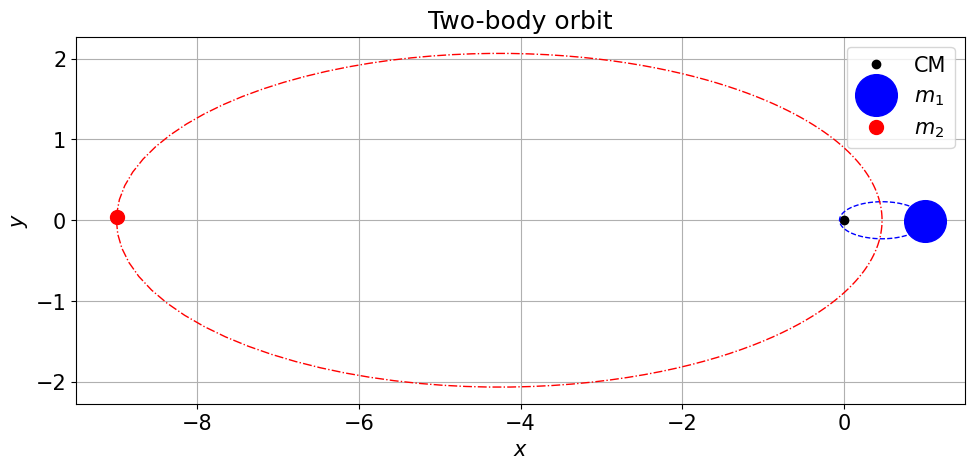

In [4]:
# constants
k, mu, L = 1, 1, 1

R0, r0 = 0, 10
V0, v0 = 0, L/(mu*r0)

# m1 is massive object and m2 is a satellite
m1 = 10
m2 = m1*mu / (m1 - mu)
assert m1 > 1 and m2 > 1, "masses must be greater than 1"

abstol = 1e-9
reltol = abstol

# initial values
RR_0 = np.array([0,  0])
VV_0 = np.array([V0, 0])
rr_0 = np.array([r0, 0])
vv_0 = np.array([0, v0])

xx1_0 = RR_0 + m2/(m1 + m2)*rr_0
xx2_0 = RR_0 - m1/(m1 + m2)*rr_0

vv1_0 = VV_0 + m2/(m1 + m2)*vv_0
vv2_0 = VV_0 - m1/(m1 + m2)*vv_0

Y_init = np.array([xx1_0, xx2_0, vv1_0, vv2_0])
h_init = 0.1
tlim   = 0, 24*np.pi

# derivatives
def F(t, Y):
    xx1, xx2, vv1, vv2 = Y
    r_squared = sum((xx1 - xx2)**2)
    F12 = -k/r_squared**1.5 * (xx1 - xx2)
    F21 = -F12
    return np.array([vv1, vv2, F12/m1, F21/m2])

# solve ode
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

# unpack result
xx1, xx2, vv1, vv2 = map(np.array, zip(*Y))

RR = (m1*xx1 + m2*xx2)/(m1 + m2)
VV = (m1*vv1 + m2*vv2)/(m1 + m2)

rr = xx1 - xx2
vv = vv1 - vv2

XX1 = xx1 - RR # position of m_1 in CM frame
XX2 = xx2 - RR # position of m_2 in CM frame

# drawing
plt.figure(figsize=[10, 10])

plt.subplot(1, 1, 1).set_aspect("equal")
plt.plot(0, 0, 'ok', label="CM")
plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$m_1$")
plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$m_2$")
plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Two-body orbit")

plt.tight_layout()
plt.show()

In [5]:
#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [1.2, 0, 0, -1.04955751] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 24 * np.pi 
absolt = 1e-9
reltol = abstol

#editting 고려사항
m = 1e-3 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])